In [2]:
import numpy as np
import pandas as pd
import nannyml as nml
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import seaborn as sns

In [3]:
def train_val_test_split(data, target, n_train, n_val, n_test):
    # start train index is generated randomly and we make sure
    # to leave space of the validation and test
    idx_train_start = np.random.randint(0, len(data) - n_train - n_val - n_test)
    idx_train_end = idx_train_start + n_train

    # validation set is adjacent to the train set
    idx_val_start = idx_train_end
    idx_val_end = idx_val_start + n_val

    # test set can be at any point after the validation set
    # it doesn't need to be adjacent to it
    idx_test_start = np.random.randint(idx_val_end, len(data) - n_test)
    idx_test_end = idx_test_start + n_test
    # idx_test_start = idx_val_end + 1
    # idx_test_end = len(data) - 1
    
    # split data
    X_train = data.iloc[idx_train_start:idx_train_end]
    X_val = data.iloc[idx_val_start:idx_val_end]
    X_test = data.iloc[idx_test_start:idx_test_end]

    # split targets
    y_train = target.iloc[idx_train_start:idx_train_end]
    y_val = target.iloc[idx_val_start:idx_val_end]
    y_test = target.iloc[idx_test_start:idx_test_end]
    
    # TODO: return only 3 objects df_train, ... targets next to data
    return X_train, X_val, X_test, y_train, y_val, y_test

In [4]:
def compute_model_errors(data, target, model, n_train, n_val, n_test):
    # create random split
    X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(data, target, n_train, n_val, n_test)
    
    # train the model
    model.fit(X_train, y_train)
    
    # make predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    # calculate errors
    train_errors = np.abs(y_train - y_train_pred)
    val_errors = np.abs(y_val - y_val_pred)
    test_errors = np.abs(y_test - y_test_pred)
    
    return train_errors, val_errors, test_errors

In [5]:
def generate_model_errors_dataframe(train_errors, val_errors, test_errors, simulation_id):
    train_errors_df = pd.DataFrame(train_errors)
    train_errors_df['partition'] = 'train'

    val_errors_df = pd.DataFrame(val_errors)
    val_errors_df['partition'] = 'val'

    test_errors_df = pd.DataFrame(test_errors)
    test_errors_df['partition'] = 'test'

    errors_df = pd.concat([train_errors_df, val_errors_df, test_errors_df])
    errors_df['index'] = errors_df.index
    errors_df = errors_df.rename(columns={"MedHouseVal": "error"})
    errors_df['model_age'] = (errors_df.index - val_errors.index[-1]).days
    errors_df['simulation_id'] = simulation_id
    
    return errors_df

In [6]:
def evaluation_runner(data, target, model, n_train, n_val, n_test, n_simulations=1):
    
    # empty error lists
    errors_df_list = []
    
    # for every simulation compute the models errors, append the errors to the error lists
    for i in range(n_simulations):
        train_errors, val_errors, test_errors = compute_model_errors(data, target, model, n_train, n_val, n_test)
    
        # generate a single error dataframe
        errors_df = generate_model_errors_dataframe(train_errors, val_errors, test_errors, i)
        errors_df_list.append(errors_df)
    
    errors_df = pd.concat(errors_df_list)
    
    return errors_df

In [57]:
def get_good_models_errors(errors_df):
    # TODO: clean this function
    daily_errors_df = errors_df.groupby(['model_age', 'partition', 'simulation_id'])['error'].mean().reset_index()
    mean_train_errors = daily_errors_df[daily_errors_df['partition'] == 'train'].groupby(['simulation_id']).agg(mean_train_error=('error','mean')).reset_index()
    daily_errors_df = pd.merge(daily_errors_df, mean_train_errors, on='simulation_id', how='inner')
    std_train_errors = daily_errors_df[daily_errors_df['partition'] == 'train'].groupby(['simulation_id']).agg(std_train_error=('error','std')).reset_index()
    daily_errors_df = pd.merge(daily_errors_df, std_train_errors, on='simulation_id', how='inner')
    mean_val_errors = daily_errors_df[daily_errors_df['partition'] == 'val'].groupby(['simulation_id']).agg(mean_val_error=('error','mean')).reset_index()
    daily_errors_df = pd.merge(daily_errors_df, mean_val_errors, on='simulation_id', how='inner')
    
    daily_errors_df['valid_model'] = np.where(daily_errors_df['mean_val_error'] <= daily_errors_df['mean_train_error'] + 
                                          3 * daily_errors_df['std_train_error'], True, False)
    
    daily_errors_valid_models_df = daily_errors_df[daily_errors_df['valid_model'] == True]
    daily_errors_valid_models_df['error_rel'] = daily_errors_valid_models_df['error'] / daily_errors_valid_models_df['mean_val_error']
    
    return daily_errors_valid_models_df

In [58]:
data, target = fetch_california_housing(as_frame=True, return_X_y=True)
timestamp = pd.date_range(start='1/1/2018', periods=len(data), freq='H')
data.index = timestamp
target.index = timestamp

n_train = 5000
n_val = 2500
n_test = 1000
model = LinearRegression()

errors_df = evaluation_runner(data, target, model, n_train, n_val, n_test, n_simulations=100)
daily_errors_valid_models_df = get_good_models_errors(errors_df)

/var/folders/b_/6mg70q8119g90vllmzk0k3dm0000gn/T/ipykernel_31160/163723948.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_errors_valid_models_df['error_rel'] = daily_errors_valid_models_df['error'] / daily_errors_valid_models_df['mean_val_error']


In [59]:
daily_errors_valid_models_df[['simulation_id', 'valid_model']].drop_duplicates()['valid_model'].value_counts()

True    94
Name: valid_model, dtype: int64

In [60]:
val_mean_error = daily_errors_valid_models_df[daily_errors_valid_models_df['partition'] == 'val']['error'].mean()
val_std_error = daily_errors_valid_models_df[daily_errors_valid_models_df['partition'] == 'val']['error'].std()
lower_threshold = 0 # train_mean_error - 3 * train_std_error
upper_threshold = val_mean_error + 3 * val_std_error

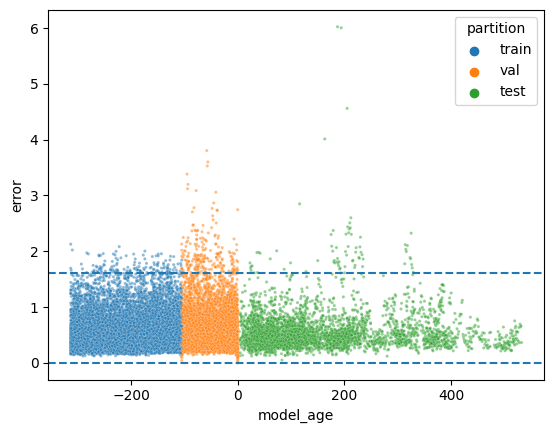

In [61]:
sns.scatterplot(data=daily_errors_valid_models_df, x='model_age', y='error', hue='partition', s=5, alpha=0.5)

plt.axhline(y=lower_threshold, ls='--')
plt.axhline(y=upper_threshold, ls='--')

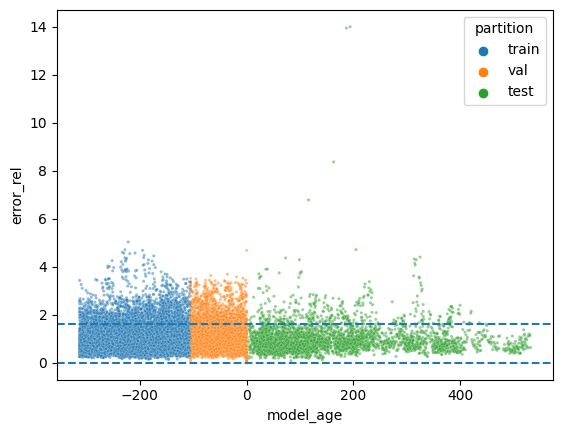

In [62]:
sns.scatterplot(data=daily_errors_valid_models_df, x='model_age', y='error_rel', hue='partition', s=5, alpha=0.5)

plt.axhline(y=lower_threshold, ls='--')
plt.axhline(y=upper_threshold, ls='--')

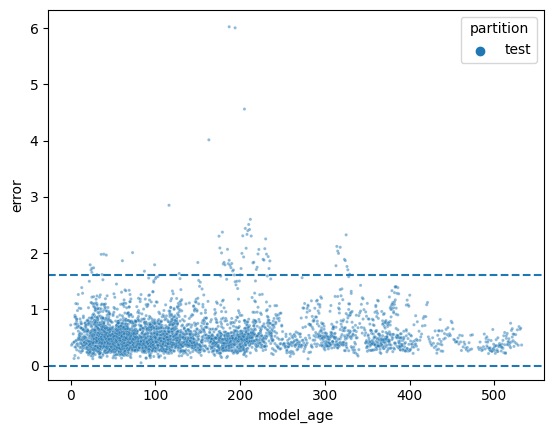

In [65]:
sns.scatterplot(data=daily_errors_valid_models_df[daily_errors_valid_models_df['partition'] == 'test'],
                x='model_age', y='error', hue='partition', s=5, alpha=0.5)

plt.axhline(y=lower_threshold, ls='--')
plt.axhline(y=upper_threshold, ls='--')

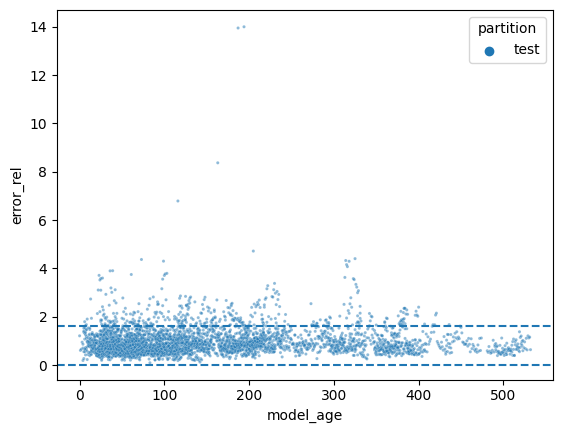

In [66]:
sns.scatterplot(data=daily_errors_valid_models_df[daily_errors_valid_models_df['partition'] == 'test'],
                x='model_age', y='error_rel', hue='partition', s=5, alpha=0.5)

plt.axhline(y=lower_threshold, ls='--')
plt.axhline(y=upper_threshold, ls='--')

In [67]:
daily_errors_valid_models_df['degradation'] = daily_errors_valid_models_df['error'] > upper_threshold

In [68]:
degraded_models_df = daily_errors_valid_models_df[daily_errors_valid_models_df['degradation'] == True]
degraded_models_df = degraded_models_df.groupby(['simulation_id', 'degradation']).agg(degradation_count=('degradation','count')).reset_index()

In [69]:
len(degraded_models_df) / len(daily_errors_valid_models_df['simulation_id'].unique()) * 100

91.48936170212765

In [70]:
len(daily_errors_valid_models_df['simulation_id'].unique()) - len(degraded_models_df)

8

TODO:

- allow chunks
- elaborate on the plots
- review thresholds